Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
##!pip install tensorflow

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# additional libraries required
from glob import glob
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
#from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.regularizers import l2

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding


In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_directory = '/content/gdrive/My Drive/Machine Learning/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration'

data_dir_train = pathlib.Path(root_directory + '/Train')
data_dir_test = pathlib.Path(root_directory + '/Test')

In [4]:
#using the glob function search/retieve image files with a .jpg extension in the specific directories
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset= "training",
    seed = 123,
    image_size =(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset ="validation",
    seed = 123,
    image_size =(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

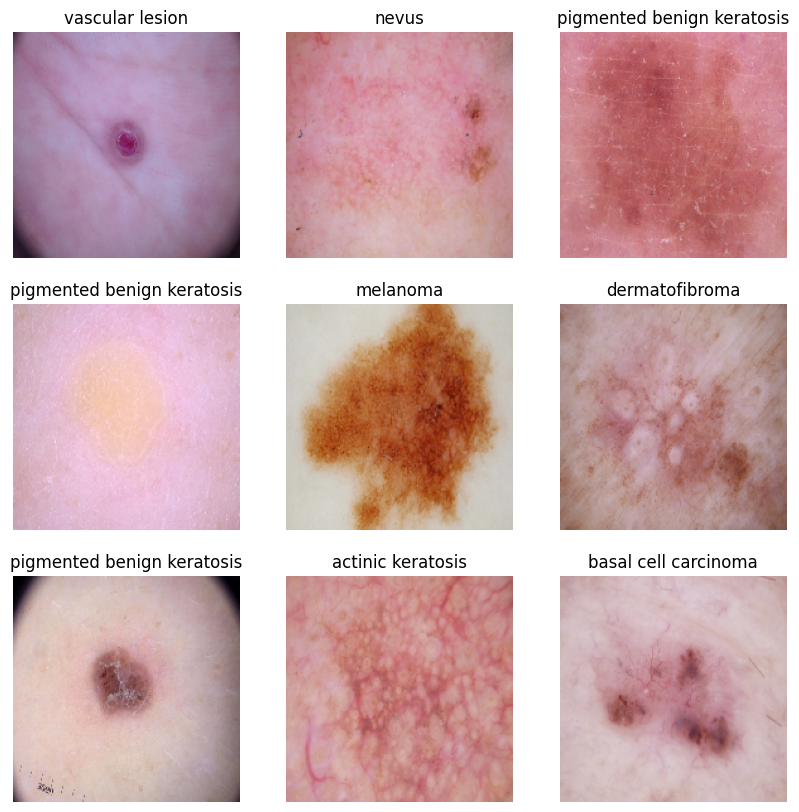

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

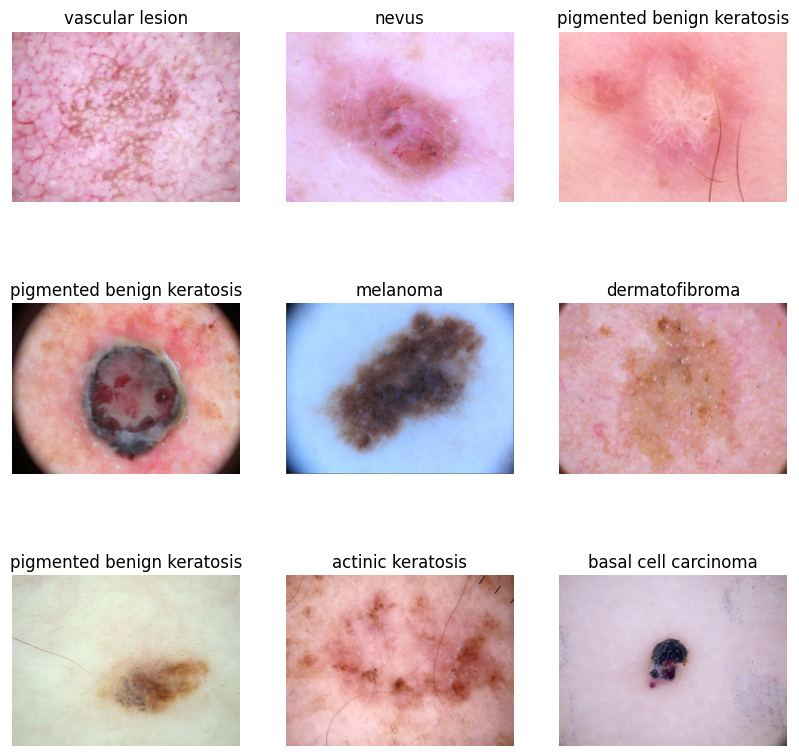

In [10]:
#plotting additional images for random classes
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[labels[i]])
  plt.imshow(image)
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
# Creating a CNN model (Experiment 1 - without drop outs)

#input_shape = (180,180,3)

num_classes = len(class_names)

model = Sequential()

# Normalising the pixel values between (0,1) from (0,255)
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layers (2 X 32 filter of kernel size 3)
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#Second Convulation Layers (2 X 64 filter of kernel size 3)
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#Third Convulation Layers (2 X 128 filter of kernel size 3)
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

#Dense Layer
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
# SGD (Stochastic Gradient Descent) and Adam (Adaptive Moment Estimation) are both optimization algorithms used in deep learning for training neural networks
# We will use sgd in this iteration, as it is computationally less expensive than adam. However we risk getting stuck in the local minima and a slower convergence rate

model.compile(optimizer='sgd',
              loss= 'sparse_categorical_crossentropy', #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 32)     896       
 er)                                                             
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 module_wrapper_1 (ModuleWra  (None, 178, 178, 32)     9248      
 pper)                                                           
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                        

### Train the model

In [15]:
# training the model for 20 epochs and with a batch sise of 32
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size = batch_size,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 668s 3s/step - loss: 2.4004 - accuracy: 0.4018 - val_loss: 3.7754 - val_accuracy: 0.0537
Epoch 2/20
56/56 [==============================] - 6s 106ms/step - loss: 1.1577 - accuracy: 0.5904 - val_loss: 4.9836 - val_accuracy: 0.0537
Epoch 3/20
56/56 [==============================] - 6s 106ms/step - loss: 0.7028 - accuracy: 0.7511 - val_loss: 5.1137 - val_accuracy: 0.0694
Epoch 4/20
56/56 [==============================] - 6s 113ms/step - loss: 0.3676 - accuracy: 0.8845 - val_loss: 5.8546 - val_accuracy: 0.1767
Epoch 5/20
56/56 [==============================] - 6s 105ms/step - loss: 0.2058 - accuracy: 0.9302 - val_loss: 4.9867 - val_accuracy: 0.1700
Epoch 6/20
56/56 [==============================] - 6s 105ms/step - loss: 0.1357 - accuracy: 0.9542 - val_loss: 3.7274 - val_accuracy: 0.2595
Epoch 7/20
56/56 [==============================] - 6s 103ms/step - loss: 0.1000 - accuracy: 0.9654 - val_loss: 2.8805 - val_accuracy: 0.3423
Epoch 8

### Visualizing training results

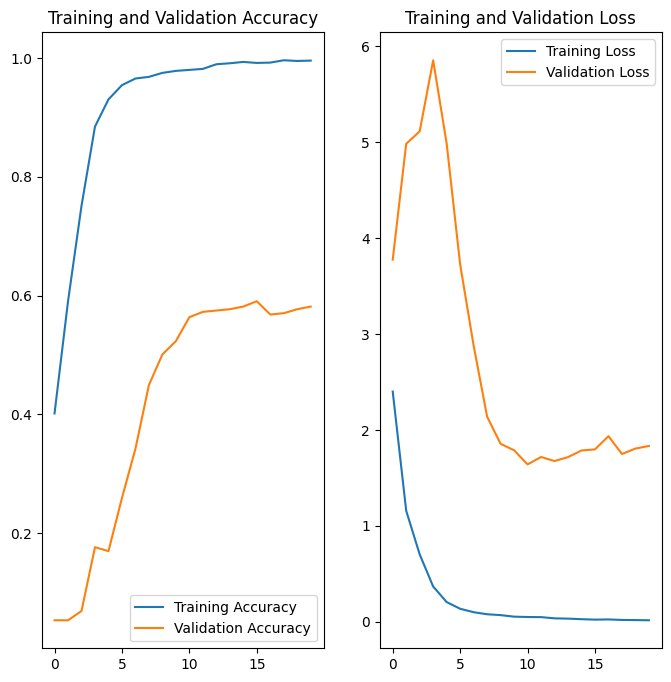

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
* The model seems to be fairing well on the Training data but poorly on validation data.

In [17]:
# Let's analyse the model -

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)




14/14 [==============================] - 0s 29ms/step - loss: 1.8335 - accuracy: 0.5817
Accuracy:  0.9347098469734192
Validation Accuracy:  0.5816555023193359
Loss:  0.163824200630188
Validation Loss 1.8335371017456055


### Write your findings here

*  Since we have a good(93%) training accurancy and poor validation accuracy (58%) it could signify that our model is performing badly and overfitting the data.
* We may thus need to improve the model by generalising it further.
* We could also look at improving the quality of the training data i.e. check for class variations and imbalances and add better image quality (data augmentation - image flipping,Zooming and rotation)
* We could also look at changing some of the hyperparameters of the model.


In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

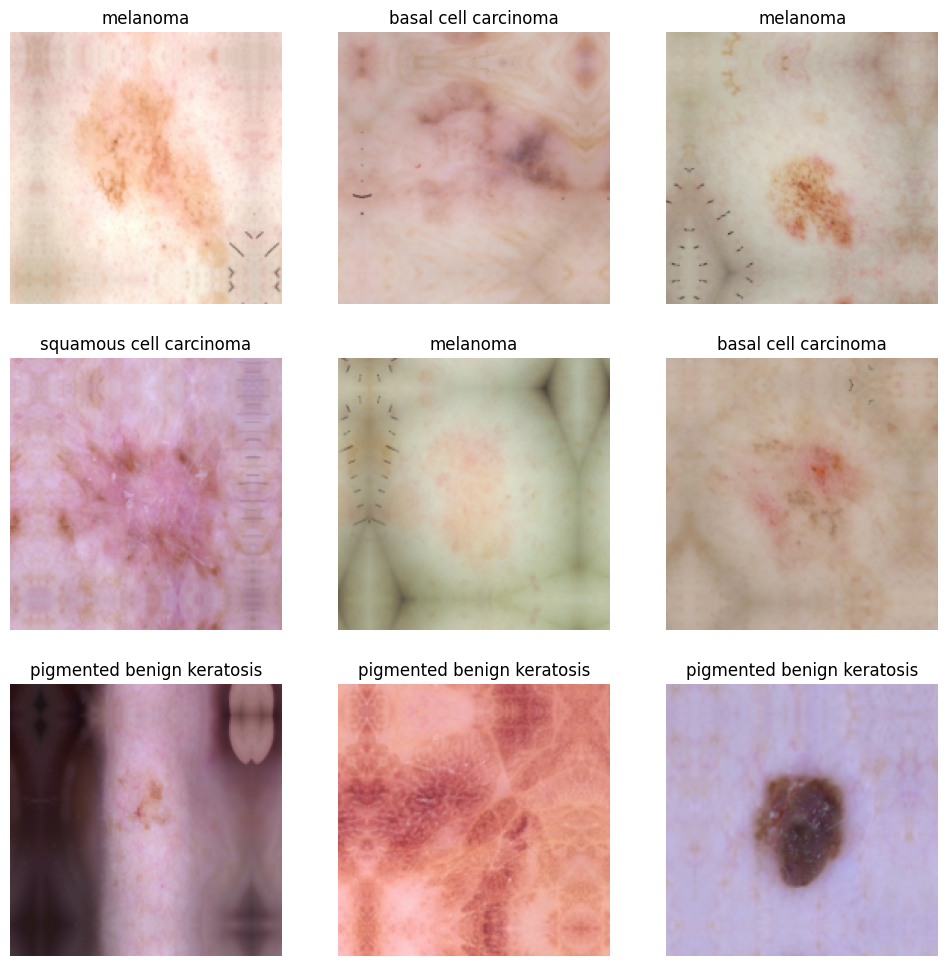

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here (Experiment - 2 with drop outs and data augmentation layer)

#Data Augmentation and Rescaling layer

model = Sequential([data_augument,layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3))])

#First Convulation layers (2 X 32 filter of kernel size 3)
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Second Convulation Layers (2 X 64 filter of kernel size 3)
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Third Convulation Layers (2 X 128 filter of kernel size 3)
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

#Dense Layer
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_12 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 batch_normalization_6 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 module_wrapper_13 (ModuleWr  (None, 178, 178, 32)     9248      
 apper)                                                          
                                                      

### Compiling the model

In [21]:
model.compile(optimizer='sgd',
             loss= 'sparse_categorical_crossentropy', #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

### Training the model

In [22]:
# training the model for 20 epochs and with a batch sise of 32
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  validation_data = val_ds,
  batch_size = batch_size,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 12s 170ms/step - loss: 5.3646 - accuracy: 0.2974 - val_loss: 2.9224 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 9s 161ms/step - loss: 1.7921 - accuracy: 0.4068 - val_loss: 3.1054 - val_accuracy: 0.1521
Epoch 3/20
56/56 [==============================] - 9s 163ms/step - loss: 1.6269 - accuracy: 0.4336 - val_loss: 4.9845 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 9s 161ms/step - loss: 1.5400 - accuracy: 0.4699 - val_loss: 4.4087 - val_accuracy: 0.1588
Epoch 5/20
56/56 [==============================] - 9s 159ms/step - loss: 1.5052 - accuracy: 0.4727 - val_loss: 4.8397 - val_accuracy: 0.1588
Epoch 6/20
56/56 [==============================] - 9s 158ms/step - loss: 1.4555 - accuracy: 0.5011 - val_loss: 4.5048 - val_accuracy: 0.2550
Epoch 7/20
56/56 [==============================] - 9s 159ms/step - loss: 1.4014 - accuracy: 0.5117 - val_loss: 3.9355 - val_accuracy: 0.2662
Epoch

### Visualizing the results

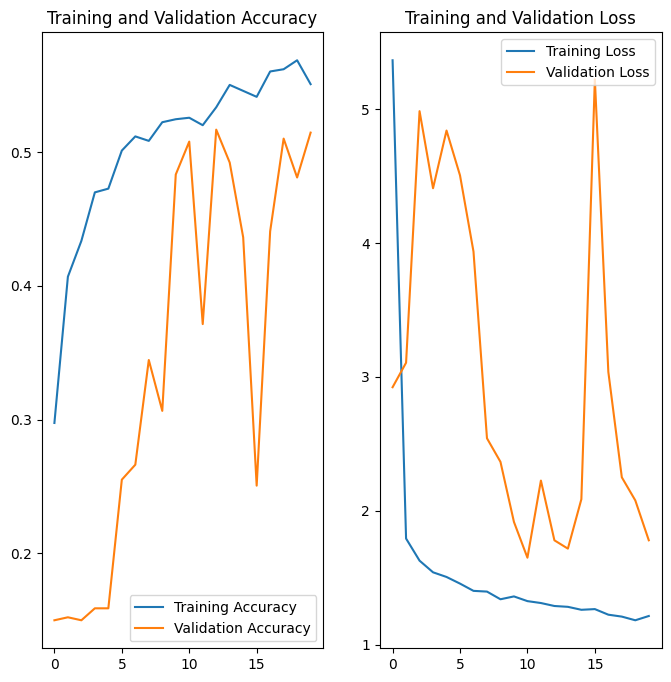

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

* The Training accuracy dropped significantly after using the drop out and data augmentation (from 93% to 55%). However the Test accuracy dropped marginally from (58% to 51%). 
* Since, the train accuracy is low it seems to indicate undefitting. We would thus need to augment our intial dataset with additional images. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

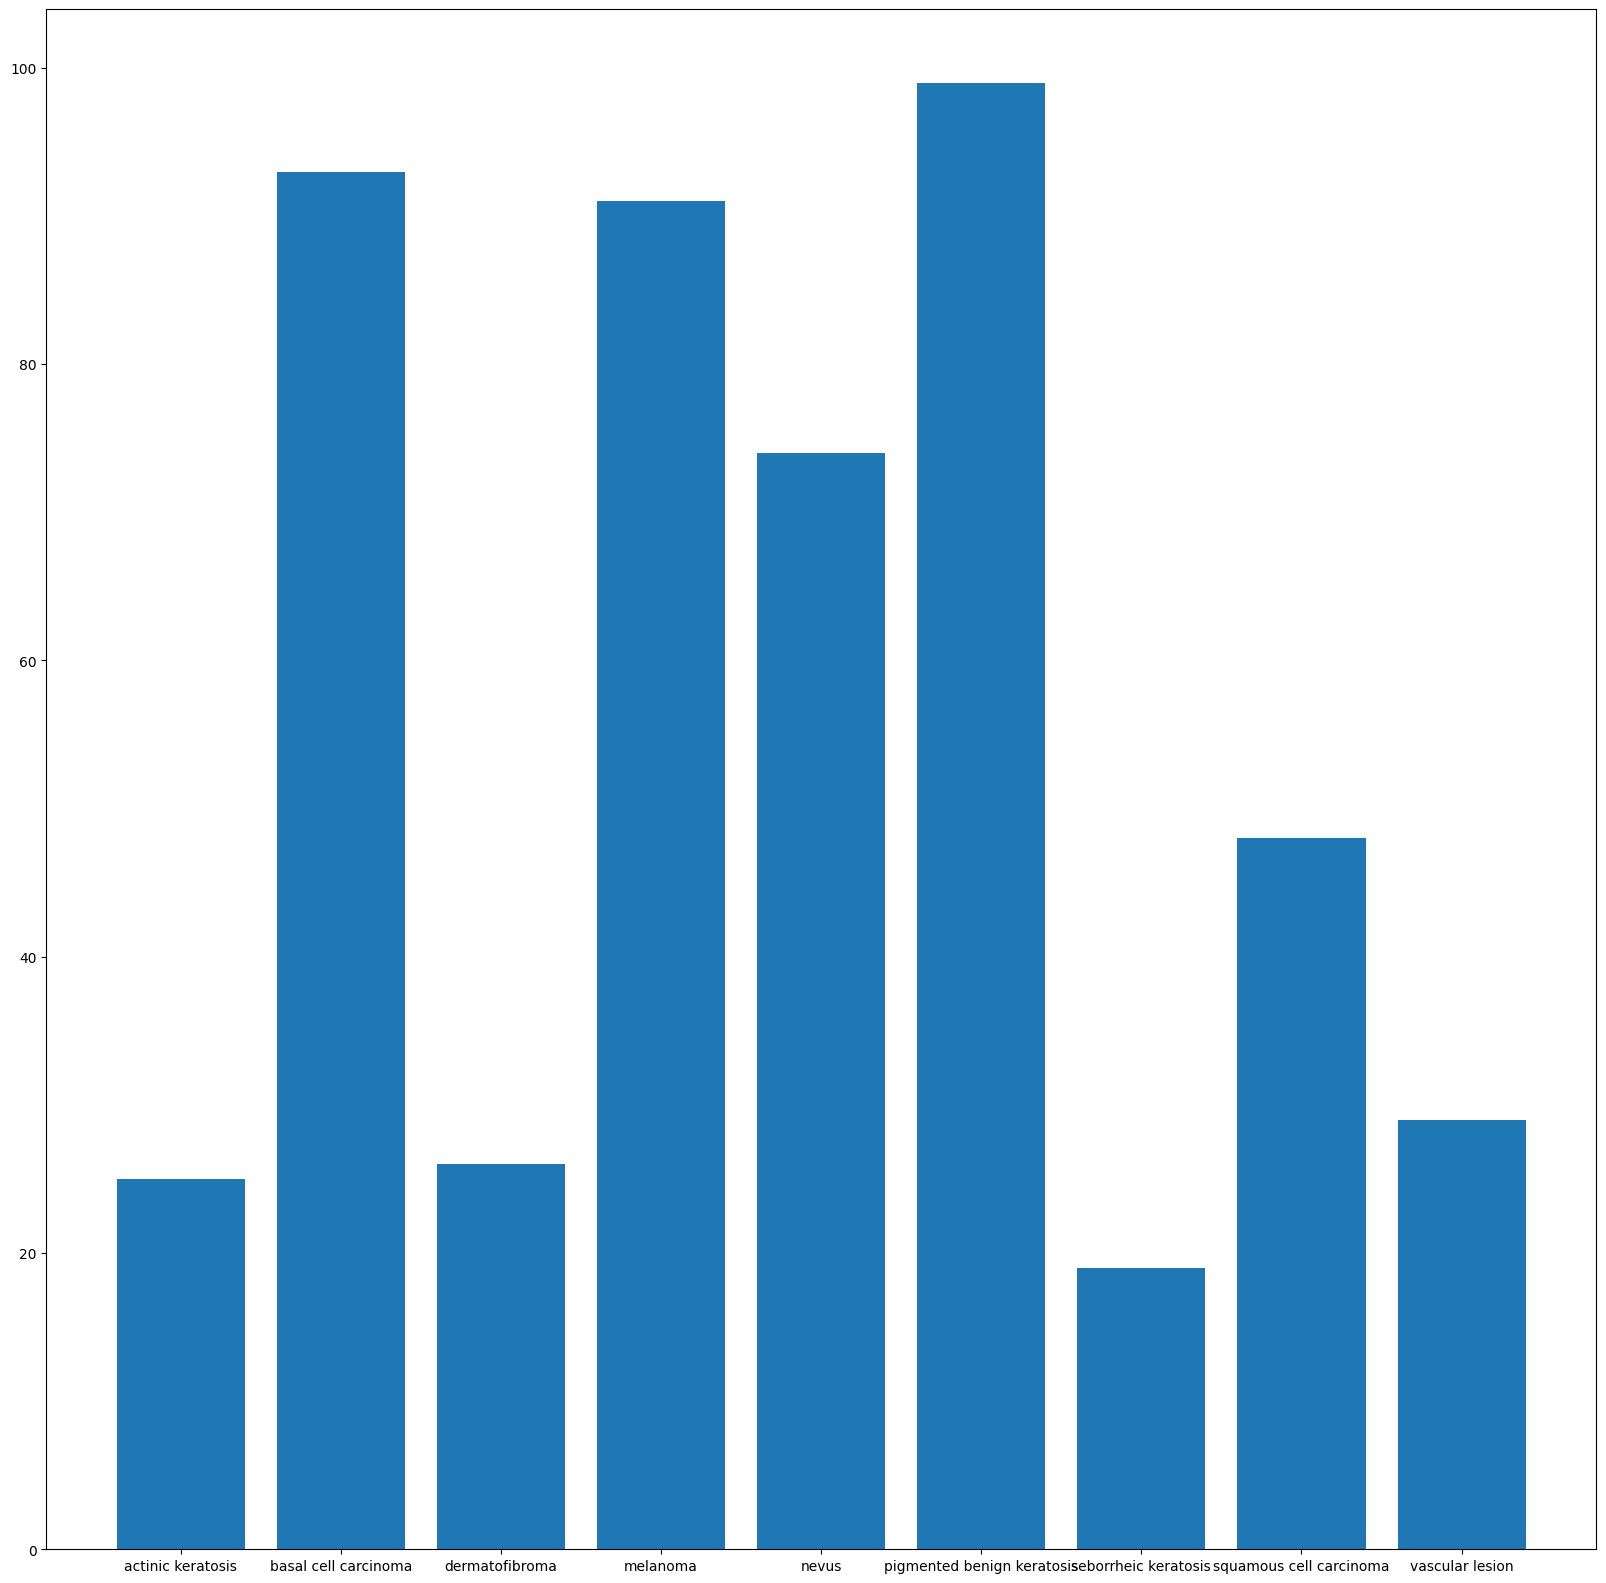

In [24]:
## Your code goes here.

import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
* Answer - Seborrheic Keratosis

#### - Which classes dominate the data in terms proportionate number of samples?

* Answer - Pigmented benign keratosis, followed by basal cell carcinoma and melanoma

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="/content/gdrive/My Drive/Machine Learning/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7160EFAD40>: 100%|██████████| 500/500 [00:21<00:00, 23.07 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7160FDFF40>: 100%|██████████| 500/500 [00:20<00:00, 24.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7160F52DA0>: 100%|██████████| 500/500 [00:22<00:00, 21.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2816x2112 at 0x7F716017E770>: 100%|██████████| 500/500 [01:42<00:00,  4.88 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F71602E0820>: 100%|██████████| 500/500 [01:33<00:00,  5.36 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7160EF8640>: 100%|██████████| 500/500 [00:21<00:00, 23.65 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F71E0185BA0>: 100%|██████████| 500/500 [00:49<00:00, 10.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7160375F30>: 100%|██████████| 500/500 [00:21<00:00, 23.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F71601A2620>: 100%|██████████| 500/500 [00:23<00:00, 21.69 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025196.jpg_09c72397-53f6-4f36-9135-5491fefb1cdc.jpg',
 '/content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029932.jpg_162271d4-f6a6-4272-a798-93e15d6aeeaf.jpg',
 '/content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026720.jpg_6555b6e6-541e-49aa-9ad8-22c50098bcd7.jpg',
 '/content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032349.jpg_ef0abf77-554a-4256-a1bb-e560f87d90d3.jpg',
 '/content/gdrive/My Drive/AI-ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [30]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [31]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
#new_df = train_ds.append(df2)
new_df = df2

In [32]:
new_df['Label'].value_counts()

squamous cell carcinoma       500
seborrheic keratosis          500
melanoma                      500
basal cell carcinoma          500
vascular lesion               500
nevus                         500
pigmented benign keratosis    500
dermatofibroma                500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train = "/content/gdrive/My Drive/Machine Learning/Assignments/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  #subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  #subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [36]:
## your code goes here

num_classes = 9

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layers (2 X 32 filter of kernel size 3)
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Second Convulation Layers (2 X 64 filter of kernel size 3)
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Third Convulation Layers (2 X 128 filter of kernel size 3)
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

#Dense Layer
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_27 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 batch_normalization_12 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 module_wrapper_28 (ModuleWr  (None, 178, 178, 32)     9248      
 apper)                                                          
                                                                 
 batch_normalization_13 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                     

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [37]:
## your code goes here

model.compile(optimizer='sgd',
             loss= 'sparse_categorical_crossentropy', #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

#### **Todo:**  Train your model

In [38]:
epochs = 50
## Your code goes here, use 50 epochs.
#history = # your model fit code

batch_size = 32

history = model.fit(
  train_ds,
  validation_data = val_ds,
  batch_size = batch_size,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 44s 242ms/step - loss: 2.6201 - accuracy: 0.3520 - val_loss: 7.5507 - val_accuracy: 0.1151
Epoch 2/50
169/169 [==============================] - 41s 234ms/step - loss: 1.4131 - accuracy: 0.4753 - val_loss: 4.1490 - val_accuracy: 0.2079
Epoch 3/50
169/169 [==============================] - 45s 260ms/step - loss: 1.2551 - accuracy: 0.5341 - val_loss: 1.9877 - val_accuracy: 0.4343
Epoch 4/50
169/169 [==============================] - 44s 250ms/step - loss: 1.1148 - accuracy: 0.5914 - val_loss: 1.2738 - val_accuracy: 0.5739
Epoch 5/50
169/169 [==============================] - 41s 235ms/step - loss: 0.9711 - accuracy: 0.6504 - val_loss: 1.1575 - val_accuracy: 0.6295
Epoch 6/50
169/169 [==============================] - 41s 235ms/step - loss: 0.8913 - accuracy: 0.6691 - val_loss: 0.8412 - val_accuracy: 0.7075
Epoch 7/50
169/169 [==============================] - 40s 231ms/step - loss: 0.7977 - accuracy: 0.7070 - val_loss: 0.8318 - val_ac

#### **Todo:**  Visualize the model results

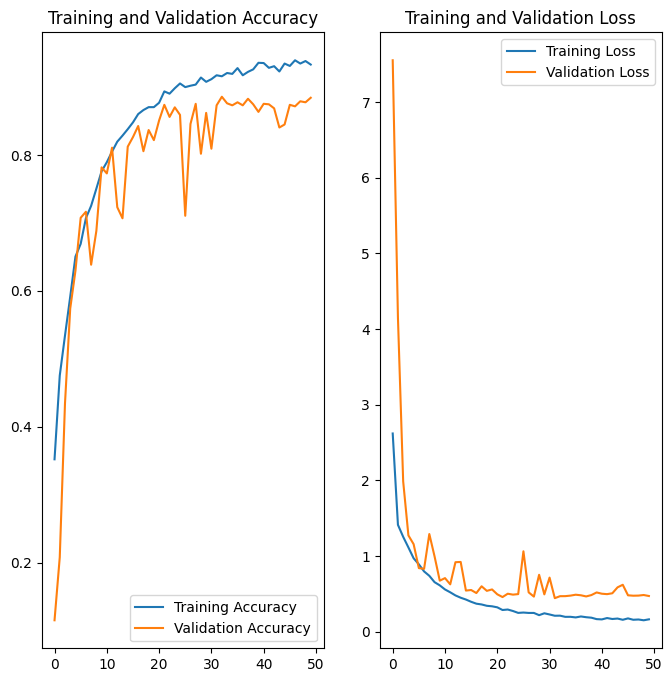

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [40]:
# Let's analyse our final model -

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Train Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Train Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 7s 151ms/step - loss: 0.4729 - accuracy: 0.8842
Train Accuracy:  0.9634643793106079
Validation Accuracy:  0.8841871023178101
Train Loss:  0.08269419521093369
Validation Loss 0.4728609323501587


* We tried to re-balance the category class imbalance by increasing the number of images per class category (Augmentation) proportionately. This resulted in better training and test accuracy.

* By previously applying data augmentation we also improved the data quality by adding rotated, flipped and zoomed versions of the source images.

* We also added additional drop out layers in subsequent models that helped reduce the model complexity and generalise the model further.

* We can conclude that the resultant model is now more generalised and is not overfitting.